In [ ]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import random
import math
import pandas as pd
import cvxpy as cp
from scipy.optimize import fsolve
import time

In [ ]:
M=2000
ite=10
dim_n=3
T=1
delta = torch.tensor(T/(ite))
sigma=0.2
mu=0.3
A0=0.0
gamma=0.0
kappa=0.2
rho=5
alpa=0.8
X0=10000
neuron_model_psi=20

In [ ]:
model= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
    #torch.nn.BatchNorm1d(num_features=neuron_model_psi),
    torch.nn.ReLU(),
    #torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    #torch.nn.ReLU(),
    # torch.nn.Linear(neuron_model_psi, neuron_model_psi_2),
    # torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    #torch.nn.BatchNorm1d(num_features=neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [ ]:
t=torch.zeros([M,1])
D=torch.zeros([M,1])
#D=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
R=torch.FloatTensor(M,1).uniform_(X0*0.9,X0*1.1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
x=torch.cat((t,D,R),dim=1)
# print(x)
# print(x.shape)

In [ ]:
def update(x3,psi):
  t=(x3[:,0]+(1/ite))
  #print(psi.squeeze(1).shape,x1[:,1].shape)
  #D = (x3[:,1]+kappa*psi)*torch.exp(-rho*delta)
  D = (x3[:,1]+kappa*torch.pow(torch.abs(psi),alpa))*torch.exp(-rho*delta)
  #D = (x3[:,1]+kappa*torch.pow(psi,alpa))*torch.exp(-rho*delta)
  R= x3[:,2]-psi
  #print(R.shape)
  up=torch.cat((t.unsqueeze(1),D.unsqueeze(1),R.unsqueeze(1)),dim=1)
  #print('up shape=', up.shape)
  return up

def loss_func(x2,psi):
  loss=(x2[:,1]*psi+(kappa/2.0)*torch.pow(torch.abs(psi),alpa+1))
  #loss = x2[:,1]*psi+(kappa/2.0)*torch.pow(psi,alpa+1)
  return loss

def unit(x1,model):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(u,model):
  loss=torch.zeros(M,ite)
  psi=torch.zeros(M,ite)
  for i in range(ite+1):
    if(i!=ite):
      psi_run,loss_run,u_run=unit(u,model)
      #print('los func=',psi_run.shape,loss_run.shape)
      loss[:,i]=loss_run
      #print(loss)
      psi[:,i]=psi_run
      #print(psi)
      u=u_run
      #print(u)
    else:
      #print(torch.sum(psi,dim=1),R.squeeze(1))
      psi_ter=R.squeeze(1)-torch.sum(psi,dim=1)
      loss_ter=loss_func(u,psi_ter)
      #print('ter',loss_ter.shape)
  #print(torch.sum(loss,dim=1))
  loss=torch.sum(loss,dim=1)+loss_ter
  #print(loss.shape)
  return torch.mean(loss)

Training

In [ ]:
lr1 = 8e-3
max_epoch = 5000
optimizer = optim.Adam(model.parameters(), lr1)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.001, total_iters=6000)
#print(psi.shape)
start=time.time()
for epoch in range(max_epoch):
  optimizer.zero_grad()
  cost=loss_func_total(x,model)
  cost.backward()
  optimizer.step()
  before_lr = optimizer.param_groups[0]["lr"]
  scheduler.step()
  after_lr = optimizer.param_groups[0]["lr"]
  if (epoch % 100==0):
    print("At epoch {} the mean error is {}.".format(epoch,cost.detach()))
    print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
end=time.time()
print(end-start)

At epoch 0 the mean error is 3740620.0.
Epoch 0: SGD lr 0.0080 -> 0.0080
At epoch 100 the mean error is 746597.375.
Epoch 100: SGD lr 0.0079 -> 0.0079
At epoch 200 the mean error is 746498.0.
Epoch 200: SGD lr 0.0077 -> 0.0077
At epoch 300 the mean error is 746368.0.
Epoch 300: SGD lr 0.0076 -> 0.0076
At epoch 400 the mean error is 746208.625.
Epoch 400: SGD lr 0.0075 -> 0.0075
At epoch 500 the mean error is 746016.3125.
Epoch 500: SGD lr 0.0073 -> 0.0073
At epoch 600 the mean error is 745780.75.
Epoch 600: SGD lr 0.0072 -> 0.0072
At epoch 700 the mean error is 745490.8125.
Epoch 700: SGD lr 0.0071 -> 0.0071
At epoch 800 the mean error is 745119.5.
Epoch 800: SGD lr 0.0069 -> 0.0069
At epoch 900 the mean error is 744632.25.
Epoch 900: SGD lr 0.0068 -> 0.0068
At epoch 1000 the mean error is 743987.5.
Epoch 1000: SGD lr 0.0067 -> 0.0067
At epoch 1100 the mean error is 743150.5.
Epoch 1100: SGD lr 0.0065 -> 0.0065
At epoch 1200 the mean error is 742119.6875.
Epoch 1200: SGD lr 0.0064 -> 0

# Cost

In [ ]:
def closed_cost(y):
    cost1=0.0
    D1=0.0
    for i in range(ite+1):
        cost1+=D1*y[i]+(kappa/2.0)*np.power(y[i],alpa)
        D1=(D1+kappa*np.power(y[i],alpa))*np.exp(-rho*T/ite)
    return cost1

**Testing ** We have compared the closed form solution from Obhizaeva and Wang, our predicted solution and the solution from python convex optimization package cvxpy

In [ ]:
# from google.colab import drive
# #drive.mount('/content/drive')
# model=torch.load('/content/drive/My Drive/model_N10_alpa0.8.pth')

In [ ]:
from torch.nn.modules.pooling import MaxPool1d
M1=20
t_test=torch.zeros([M1,1])
D_test=torch.zeros([M1,1])
#D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
#R_test=torch.FloatTensor(M1,1).uniform_(50,100)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
R_test=torch.linspace(X0*0.95, X0*1.05, steps=M1).unsqueeze(1)
x_test=torch.cat((t_test,D_test,R_test),dim=1)
#print('Input=',x_test,'\n')
a=torch.zeros(M1,ite+1)
#print(a.shape)
for i in range(ite+1):
  if(i!=ite):
    #print(x_test)
    soln_pred=model(x_test).squeeze(1).detach()
    a[:,i]=soln_pred
    x_test=update(x_test,soln_pred)
    #print(x_test,'\n')
  else:
    a[:,i]=R_test.squeeze(1)-torch.sum(a,dim=1)

x1=R_test.squeeze().numpy()
# c_true=np.zeros(M1)
# c_pred=np.zeros(M1)
# c_num=np.zeros(M1)
# n_soln=np.zeros((M1,ite+1))
# t_soln=np.zeros((M1,ite+1))

for i in range(M1):
  print('size of total order=',x1[i])

  print('predicted soln=',a[i,:],'sum of all execution=',torch.sum(a[i,:]).detach())
#   pred_cost=cost(a[i,:])
#   print('predicted cost=',pred_cost.detach().numpy(),'\n')
#   c_pred[i]=pred_cost

size of total order= 9500.0
predicted soln= tensor([2407.2415,  645.2996,  621.6591,  602.6187,  587.5950,  576.0969,
         567.7073,  562.0703,  558.8789,  557.8670, 1812.9653]) sum of all execution= tensor(9499.9990)
size of total order= 9552.632
predicted soln= tensor([2420.4565,  647.9663,  623.9677,  604.6180,  589.3262,  577.5942,
         569.0004,  563.1840,  559.8346,  558.6832, 1838.0005]) sum of all execution= tensor(9552.6309)
size of total order= 9605.263
predicted soln= tensor([2433.6711,  650.6301,  626.2728,  606.6137,  591.0535,  579.0882,
         570.2902,  564.2945,  560.7873,  559.4966, 1863.0645]) sum of all execution= tensor(9605.2627)
size of total order= 9657.895
predicted soln= tensor([2446.8862,  653.2910,  628.5748,  608.6061,  592.7780,  580.5790,
         571.5767,  565.4019,  561.7371,  560.3073, 1888.1567]) sum of all execution= tensor(9657.8955)
size of total order= 9710.526
predicted soln= tensor([2460.1011,  655.9487,  630.8733,  610.5952,  594.498

Comparing the cost

Comparing solution for diffeternt testing samples

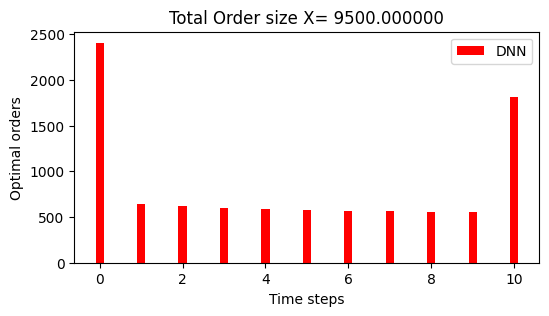

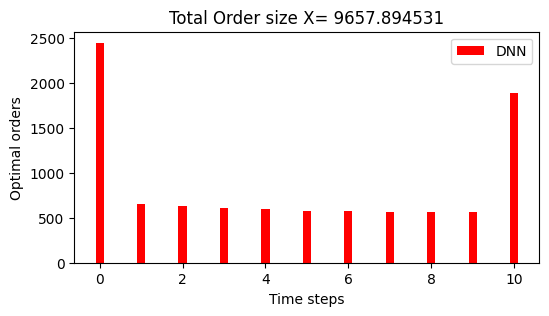

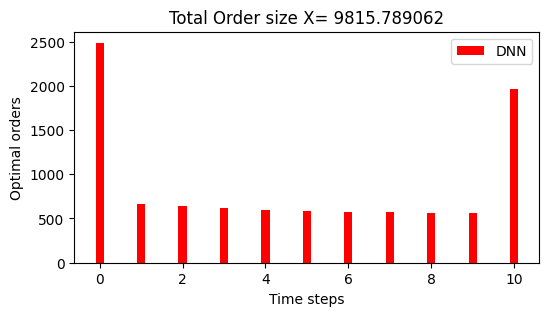

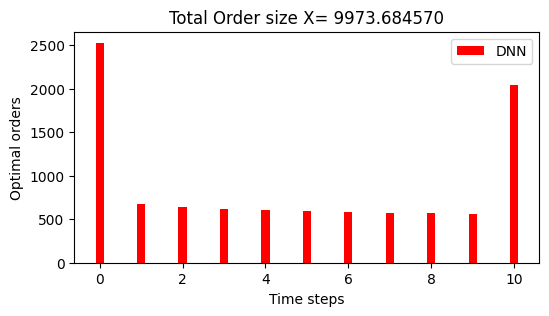

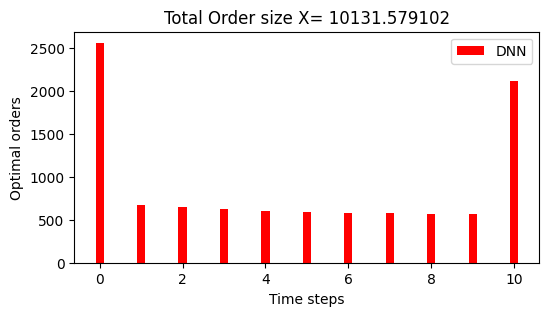

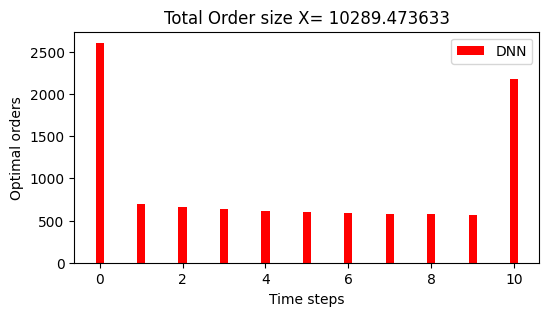

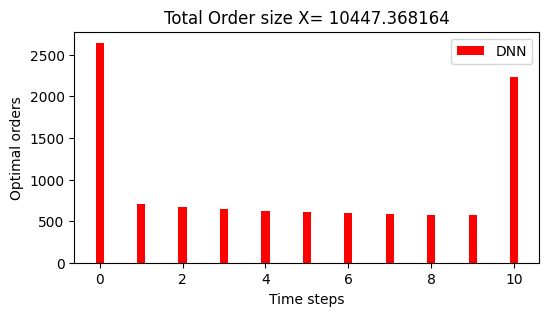

In [ ]:
p_soln=a.numpy()
t_step=np.linspace(0,ite,num=ite+1)
#name='E:/Robin research/7thECMF_PosterPresent/Figures/alpa0.8.eps'
def plotting(t):
  #print('Total order size=',x1[t],np.sum(n_soln[t]),np.sum(p_soln[t]))
  #print(n_soln[t],p_soln[t])
  plt.figure(figsize=(6,3))
  #plt.bar(t_step,t_soln[t],color='blue',width=0.3,label='Closed-Form')
  plt.bar(t_step,p_soln[t],color='red',width=0.2,label='DNN')
  #plt.bar(t_step,n_soln[t],color='green',width=0.1,label='numeric')
  plt.title('Total Order size X= %f' % (x1[t]))
  plt.xlabel('Time steps')
  plt.ylabel('Optimal orders')
  plt.legend()
  #plt.savefig('f.eps', format='eps')
  # if(t==0):
  #   plt.savefig(name,format='eps')
  # plt.show()
for i in range(0,M1,3):
  plotting(i)

Comparing solution at different time steps

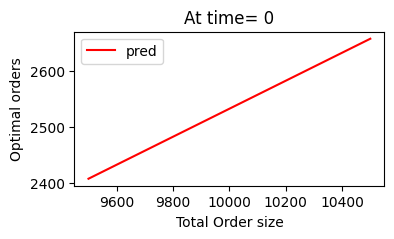

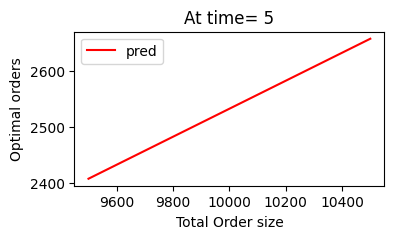

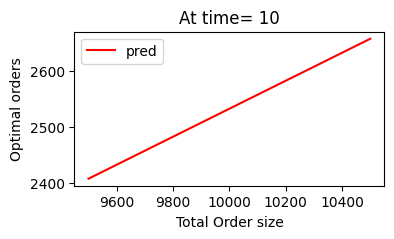

In [ ]:
#p_soln=a.numpy()
t_step=np.linspace(0,ite,num=ite+1)
X=R_test.squeeze(1).numpy()
def plotting_time(t):
  #print(t_soln[t],p_soln[t])
  plt.figure(figsize=(4,2))
  plt.plot(X,p_soln[:,0],color='red',label='pred')
  plt.title('At time= %d' % (t_step[t]))
  plt.xlabel('Total Order size')
  plt.ylabel('Optimal orders')
  plt.legend()
  plt.show
for i in range(0,t_step.shape[0],5):
  plotting_time(i)


Absolute sum of the difference between true solution, predicted solution and true soln, numeric soln at each time step

# Saving Model

In [ ]:
#torch.save(model, 'model_N10_alpa0.8.pth')